<a href="https://colab.research.google.com/github/LCaravaggio/AnalisisPredictivo/blob/master/Kaggle/2023Q2/Un_primer_LR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import json
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBRegressor
import xgboost as xg
import cupy as cp





In [5]:
y=pd.read_csv('dataset/origen.csv').averageRating
X=pd.read_csv('dataset/train.csv')
X_pred=pd.read_csv('dataset/val.csv')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=251)

In [4]:





regr = XGBRegressor(n_estimators=1100,eta=0.1,max_depth=13,device="cuda") # type: ignore
#regr = XGBRegressor(n_estimators=1200, eta=0.35, max_depth=7, multi_strategy="multi_output_tree", min_child_weight=1, subsample=1, colsample_bytree=1, gamma=0, alpha=0)
print("Training a XGBRegressor")
regr.fit(X_train, y_train)
print("Finished training the XGBRegressor")
score = regr.score(X_test, y_test)

print("R^2 score on testing data: {:.4f}".format(score)) 
# 0.7 - 0.3819 | 0.6 - 0.3845 | 0.5 - 0.3867 | 0.4 - 0.3862
# 50 - 0.3862 | 60 - 0.3875 | 70 - 0.3886 | 75 - 0.3888 | 80 - 0.3886
# 5194
# RMSE
from sklearn.metrics import mean_squared_error
y_pred = regr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))


Training a XGBRegressor
Finished training the XGBRegressor


c:\Users\ianda\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [23:09:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


R^2 score on testing data: 0.5218
RMSE: 0.971307


In [6]:

# Move the data to the GPU
X_train_gpu = cp.asarray(X_train)
y_train_gpu = cp.asarray(y_train)

In [16]:

# Train the model on the GPU

regr = XGBRegressor(n_estimators=1100,eta=0.025,max_depth=19,device="cuda",tree_method="hist",sampling_method="gradient_based",subsample=0.4) # type: ignore
#regr = XGBRegressor(n_estimators=1200, eta=0.35, max_depth=7, multi_strategy="multi_output_tree", min_child_weight=1, subsample=1, colsample_bytree=1, gamma=0, alpha=0)
print("Training a XGBRegressor")
regr.fit(X_train_gpu, y_train_gpu)
print("Finished training the XGBRegressor")
score = regr.score(X_test, y_test)

print("R^2 score on testing data: {:.4f}".format(score)) 
# 0.7 - 0.3819 | 0.6 - 0.3845 | 0.5 - 0.3867 | 0.4 - 0.3862
# 50 - 0.3862 | 60 - 0.3875 | 70 - 0.3886 | 75 - 0.3888 | 80 - 0.3886
# 5224
# RMSE
from sklearn.metrics import mean_squared_error
y_pred = regr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

Training a XGBRegressor
Finished training the XGBRegressor
R^2 score on testing data: 0.5262
RMSE: 0.966761


In [33]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.1, random_state=42)

# Create a LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)

# Set the hyperparameters for the LightGBM model
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 50,
    'learning_rate': 0.05,
    'feature_fraction': 1,
    'bagging_fraction': 0.8,
    'bagging_freq': 10,
    'verbose': 1
}

# Train the LightGBM model
num_rounds = 1000
regr = lgb.train(params, train_data, num_rounds)

# Make predictions on the validation set
y_pred = regr.predict(X_val)

from sklearn.metrics import mean_squared_error

# Compute the mean squared error
mse = mean_squared_error(y_val, y_pred)

# Compute the root mean squared error
rmse = np.sqrt(mse)

# Print the root mean squared error
print("RMSE: {:.2f}".format(rmse))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2649
[LightGBM] [Info] Number of data points in the train set: 879786, number of used features: 56
[LightGBM] [Info] Start training from score 6.881322
RMSE: 1.08


In [12]:

# Define the number of threads to use
#use max threads
from random import randint
num_threads = 16

# Define the random states to use
random_states = []
for i in range(10):
    random_states.append(randint(0, 1000))

# Define the training and testing data


# Define a function to train the model and return the R^2 score
def train_model(random_state):
    # Create a LinearForestRegressor with the specified random state
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)
    regr = XGBRegressor(n_estimators=1050,eta=0.17,max_depth=10) # type: ignore
    print("Training a XGBRegressor")
    regr.fit(X_train, y_train)
    print(f"Finished training the XGBRegressor with {random_state} random state")
    score = regr.score(X_test, y_test)

    print("R^2 score on testing data: {:.4f}".format(score)) 
    return score

# Use a ThreadPoolExecutor to run the function on multiple threads
with ThreadPoolExecutor(max_workers=num_threads) as executor:
    # Submit the function to the executor for each random state
    futures = [executor.submit(train_model, random_state) for random_state in random_states]

    # Wait for all the futures to complete and get the results
    results = [future.result() for future in futures]

# Print the average R^2 score across all the random states
print("Average R^2 score across all random states: {:.4f}".format(sum(results) / len(results)))


Training a XGBRegressor
Training a XGBRegressor
Training a XGBRegressor
Training a XGBRegressor
Training a XGBRegressor
Training a XGBRegressor
Training a XGBRegressor
Training a XGBRegressor
Training a XGBRegressor
Training a XGBRegressor
Finished training the XGBRegressor with 418 random state
Finished training the XGBRegressor with 211 random state
R^2 score on testing data: 0.6689
R^2 score on testing data: 0.6726
Finished training the XGBRegressor with 549 random state
Finished training the XGBRegressor with 631 random state
Finished training the XGBRegressor with 282 random state
R^2 score on testing data: 0.6698
R^2 score on testing data: 0.6688
R^2 score on testing data: 0.6707
Finished training the XGBRegressor with 701 random state
R^2 score on testing data: 0.6717
Finished training the XGBRegressor with 95 random state
R^2 score on testing data: 0.6718
Finished training the XGBRegressor with 735 random state
R^2 score on testing data: 0.6709
Finished training the XGBRegresso

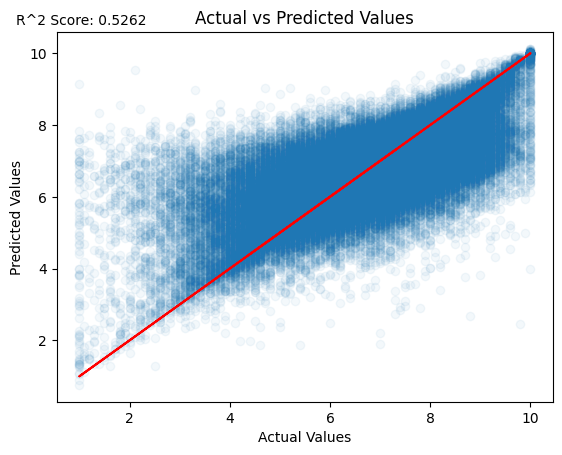

In [17]:

# Assume regr is your trained LinearForestRegressor
predictions = regr.predict(X_test)

# Create a scatter plot of predicted vs actual values with transparency
plt.scatter(y_test, predictions, alpha=0.05)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
#Subtitle with score
plt.text(0.05, 1.03, 'R^2 Score: {:.4f}'.format(score), ha='center', va='center', transform=plt.gca().transAxes)

# Plot a line for perfect correlation. This serves as a reference line.
plt.plot(y, y, 'r')

plt.show()

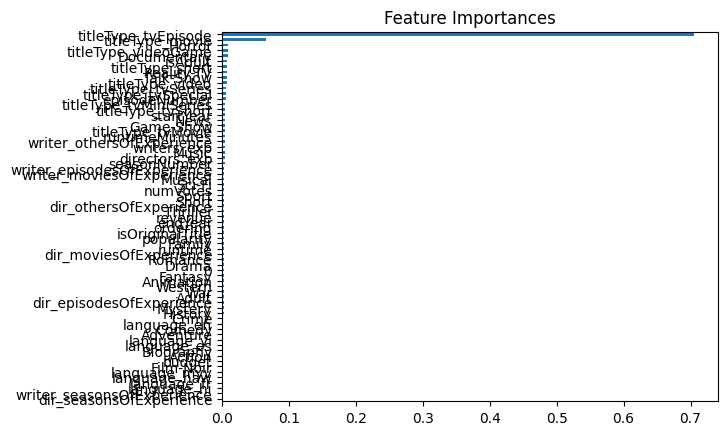

In [19]:
# Assume regr is your trained LinearForestRegressor
importances = regr.feature_importances_

# Convert to pandas Series for easier plotting
importances = pd.Series(importances, index=X.columns)

# Sort importances
importances = importances.sort_values()

# Plot
importances.plot(kind='barh')
plt.title('Feature Importances')
plt.show()


In [18]:
Yest = regr.predict(X_pred)
salida = pd.DataFrame(data={"averageRating": Yest})
salida.index = X_pred.index
salida.to_csv("predicciones/pred14.csv", sep=',',index=True,  index_label='Id')